In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import datetime
import json as jsn
import geopandas as gpd
import shapely as shply
import rle as rle
import os as os

from scipy.special import expit

from werp_projecting_sfis.get_rating_tables_and_cross_sections import * 

In [2]:
output_folder = "R:/work/rob635/Blackwater/Site_tables"

In [3]:
parentdire = '//fs1-cbr.nexus.csiro.au/{ev-mdb-outlook}/work/IRSMF_curated_results/'
filelist = os.listdir('//fs1-cbr.nexus.csiro.au/{ev-mdb-outlook}/work/IRSMF_curated_results/')
filelist = [file for file in filelist if '.nc' in file]
filelist = [parentdire + file for file in filelist if '_P0' in file]
filelist
scenarios = [file.split('0')[1] for file in filelist]
scenarios
infiles = xr.open_mfdataset(filelist, combine = 'nested', concat_dim= 'scenario')

infiles = infiles.assign_coords({'scenario' :scenarios})

In [4]:
infile_histemp = xr.open_dataset("L:/work/fre171/Spatial/silo_sfi_drill_max_temp.nc")
infile_hist = xr.open_dataset("//fs1-cbr.nexus.csiro.au/{ev-mdb-outlook}/work/IRSMF_curated_results/irsmf_sfi_P0H000_flow.nc")
infile_fut = xr.open_dataset("//fs1-cbr.nexus.csiro.au/{ev-mdb-outlook}/work/IRSMF_curated_results/irsmf_sfi_P0D000_flow.nc") 


In [5]:
qldurl = "https://water-monitoring.information.qld.gov.au/cgi/webservice.pl"
nswurl = "https://realtimedata.waternsw.com.au/cgi/webservice.exe"
vicurl = "https://data.water.vic.gov.au/WMIS/cgi/webservice.exe"

In [6]:
infile_hist

<xarray.Dataset> Size: 42MB
Dimensions:         (station: 124, time: 41638)
Coordinates:
  * station         (station) int32 496B 1 2 3 4 5 6 ... 119 120 121 122 123 124
  * time            (time) datetime64[ns] 333kB 1895-07-01 ... 2009-06-30
Data variables:
    HISName         (station) <U66 33kB ...
    AWRC_gauge      (station) <U14 7kB ...
    spatial_coords  (station) <U111 55kB ...
    lon             (station) float64 992B ...
    lat             (station) float64 992B ...
    flow            (station, time) float64 41MB ...
Attributes:
    title:           A continuous daily time series of data generated from IR...
    institution:     MDBA
    source:          IRSMF Outlook23 model results
    catchment:       Murray-Darling Basin
    history:         This data has been generated by the IRSMF for the Outloo...
    comment:         CSIRO has migrated these datasets to netcdf for the purp...
    MDBA_attrs:      Capture required attributes for MDBA data registry systems
    crs:             4283
    data variables:  Flow

In [7]:
sites_to_use = np.where(np.isfinite(infile_hist['flow']).all(dim = "time"))
sitids = infile_hist['AWRC_gauge'][sites_to_use].values

In [8]:
sitids.shape

(58,)

In [9]:
qldstations_call =requests.get( "https://water-monitoring.information.qld.gov.au/cgi/webservice.pl?%7b%22function%22:%22get_site_list%22,%22version%22:%221%22,%22params%22:%7b%22site_list%22:%22GROUP(OPEN_STATIONS)%22%7d%7d")
js = qldstations_call.json()
allqldsites = js['return']['sites']



In [10]:
qldsites = [stn for stn in sitids if np.any([ stn in stn1 for stn1 in allqldsites ])]
qldids = [ np.where([ ssn in stn for stn in allqldsites ])[0][0] for ssn in qldsites]
qldsitesdf = pd.DataFrame({"Site":qldsites, "id" :qldids,"local_ids":[allqldsites[i] for i in qldids]})
qldsitesdf

,Site,id,local_ids
0,422201,4,422201F
1,423203,393,423203A
2,423204,394,423204A


In [11]:
def query2url(url, query):
    c1, c2 = "'", "\""
    txt = re.sub(c1, c2, str(query))
    return f"{url}?{txt}".strip()

query = {\
    'function': 'get_site_list',\
    'version' : 1,\
    'params' : {\
        'site_list' : 'GROUP(SURFACE_WATER)'\
        }
    }

req_url = query2url( "https://realtimedata.waternsw.com.au/cgi/webservice.exe" , query)
req = requests.get(req_url)
print(req)
print(req.status_code)
print(req.content)
js = req.json()
allnswsites = js['return']['sites']
nswsites = [stn for stn in sitids if np.any([ stn in stn1 for stn1 in allnswsites ])]
nswsiteids = [ np.where([ ssn in stn for stn in allnswsites ])[0][0] for ssn in nswsites]

nswsitesdf = pd.DataFrame({"Site":nswsites, "id" :nswsiteids,"local_ids":[allnswsites[i] for i in nswsiteids]})

<Response [200]>
200
b'{"error_num":0,"return":{"sites":["201001","201005","201012","201015","201900","202001","202002","203002","203004","203005","203010","203012","203014","203023","203024","203030","203034","203041","203042","203056","203057","203059","203060","203061","203062","203403","203470","203900","204001","204002","204004","204006","204007","204008","204014","204015","204017","204025","204030","204031","204033","204034","204036","204037","204039","204041","204043","204046","204051","204055","204056","204067","204068","204069","204071","204400","204403","204413","204900","204906","205002","205015","205016","205017","205018","205019","206001","206008","206009","206011","206014","206018","206024","206025","206026","206032","206033","206034","206035","206036","206037","206039","206042","206402","207004","207006","207008","207009","207010","207013","207014","207015","207017","207018","208001","208003","208004","208005","208006","208007","208008","208009","208011","208015","208019

In [12]:

def query2url(url, query):
    c1, c2 = "'", "\""
    txt = re.sub(c1, c2, str(query))
    return f"{url}?{txt}".strip()

query = {\
    'function': 'get_groups',\
    'version' : 1,\
    'params' : { \
    'site_list': '405205', \
    }
    }

req_url = query2url( "https://data.water.vic.gov.au/WMIS/cgi/webservice.exe" , query)
req = requests.get(req_url)
js = req.json()
#allvicsites = js['return']['sites']
js
#allvicsites

{'error_num': 0,
 'return': [{'group_decode': 'to be at the top of the list',
   'group': 'AB',
   'value': 'FLOOD',
   'value_decode': 'All VIR Sites for Flood Zoom',
   'stations': ['405205']},
  {'group_decode': 'All sites in archive',
   'group': 'ALLA',
   'value': '10PLUS',
   'value_decode': 'sites with records longer than 10 years',
   'stations': ['405205']},
  {'group_decode': 'All sites in archive',
   'group': 'ALLA',
   'value': '30PLUS',
   'value_decode': 'sites with records longer than 30 years',
   'stations': ['405205']},
  {'group_decode': 'All sites in archive',
   'group': 'ALLA',
   'value': 'ARCHIVE',
   'value_decode': 'Archive files',
   'stations': ['405205']},
  {'group_decode': 'All sites in archive',
   'group': 'ALLA',
   'value': 'FLOWA',
   'value_decode': 'All sites with flow (Vir and Hyd)',
   'stations': ['405205']},
  {'group_decode': 'All sites in archive',
   'group': 'ALLA',
   'value': 'LEVEL',
   'value_decode': 'All sites with level (100.00 and

In [13]:

def query2url(url, query):
    c1, c2 = "'", "\""
    txt = re.sub(c1, c2, str(query))
    return f"{url}?{txt}".strip()

query = {\
    'function': 'get_site_list',\
    'version' : 1,\
    'params' : {\
        'site_list' : 'GROUP(WEB_SW)'\
        }
    }

req_url = query2url( "https://data.water.vic.gov.au/WMIS/cgi/webservice.exe" , query)
req = requests.get(req_url)
print(req)
print(req.status_code)
print(req.content)
js = req.json()
allvicsites = js['return']['sites']

vicsites = [stn for stn in sitids if np.any([ stn in stn1 for stn1 in allvicsites ])]
vicsiteids = [ np.where([ ssn in stn for stn in allvicsites ])[0][0] for ssn in vicsites]

vicsitesdf = pd.DataFrame({"Site":vicsites, "id" :vicsiteids,"local_ids":[allvicsites[i] for i in vicsiteids]})


<Response [200]>
200
b'{"error_num":0,"return":{"sites":["221001","221200","221201","221202","221203","221204","221205","221206","221207","221208","221209","221210","221211","221212","221213","221214","221216","221217","221218","221222","221223","221224","221225","221601","221602","221603","221800","221801","221802","221803","221804","222200","222201","222202","222203","222204","222205","222206","222207","222208","222209","222210","222212","222213","222214","222216","222217","222218","222219","222221","222222","222223","222400","222401","222403","222404","223200","223201","223202","223204","223205","223206","223207","223208","223209","223210","223212","223213","223214","223215","223217","223218","223402","223403","223601","223800","223801","223802","223804","224200","224201","224202","224203","224204","224205","224206","224207","224208","224209","224210","224213","224214","224215","224216","224217","224220","224222","224402","224601","224602","225019","225101","225103","225105","225106

In [14]:
sitids

array(['406202', '405232', '403241', '406265', '409017', '409025',
       '409207', '409003', '410073', '426532', '410001', '410134',
       '410005', '410130', '414203', '410021', '410040', '425010',
       '412010', '425007', '421007', '412036', '412038', '421040',
       '425012', '421001', '419045', '419015', '419007', '425004',
       '421011', '421012', '421107', '421023', '419021', '419039',
       '419026', '425003', '422001', '418026', '423001', '418049',
       '422003', '418055', '422016', '418004', '424002', '417001',
       '416052', '416018', '416001', '422201', '423203', '423204',
       '420004', '419049', '412005', '425008'], dtype='<U14')

In [18]:
for catch in sitids:
   if catch == '416001':
        use = False
        if catch in qldsitesdf['Site'].values:
            print(catch, 'qld')
            use_url =qldurl
            site_name = qldsitesdf.loc[np.where(qldsitesdf['Site'].values==catch)[0],'local_ids' ].values[0]
            discode = '140'
            apiversion = '1'
            use = True
        elif catch in nswsitesdf['Site'].values:
            print(catch, 'nsw')
            use_url =nswurl
            site_name = nswsitesdf.loc[np.where(nswsitesdf['Site'].values==catch)[0],'local_ids' ].values[0]
            discode = '141'
            use = True
            apiversion = '1'
        elif catch in vicsitesdf['Site'].values:
            print(catch, 'vic')
            use_url =vicurl
            site_name = vicsitesdf.loc[np.where(vicsitesdf['Site'].values==catch)[0],'local_ids' ].values[0]
            print(site_name)
            discode = '140'
            use = False
            apiversion = '1'
        if use:
            print('get rating')
            rating = download_rating_table(site_name, url = use_url, discharge_code= discode ,api_version= apiversion)
            print('get crossection')
            crossection = download_cross_section(site_name, url = use_url)
            if rating.shape[0] >0  and crossection.shape[0]>0 and all(rating['vt'] != rating['vt'].mean()) :
                print(catch, rating.shape[0],crossection.shape[0] )
                combinedtable = unify_tables(rating, crossection)
                combinedtable.to_csv(os.path.join(output_folder,catch+".csv"))
                rating.to_csv(os.path.join(output_folder,catch+"_rating.csv"))
                crossection.to_csv(os.path.join(output_folder,catch+"_crosssection.csv"))
                fig, axs = plt.subplots(2,2,figsize=(10,10) )
    #fig.delaxes(axs[1,1])
                axs[0,0].plot(combinedtable['level'], combinedtable['area'])
                axs[0,0].set_xlabel("Level (m)")
                axs[0,0].set_ylabel("Cross-sectional area (m^2)")
                axs[0,0].set_yscale('log')

                axs[1,0].plot(combinedtable['level'], combinedtable['discharge'])
                axs[1,0].set_xlabel("Level (m)")
                axs[1,0].set_ylabel("Discharge (m^3/s)")
                axs[1,0].set_yscale('log')

                axs[0,1].plot(combinedtable['level'], combinedtable['velocity'])
                axs[0,1].set_xlabel("Level (m)")
                axs[0,1].set_ylabel("Velocity (m/s)")

                axs[1,1].plot(combinedtable['discharge'], combinedtable['velocity'])
                axs[1,1].set_xlabel("Discharge (m^3/s)")
                axs[1,1].set_ylabel("Velocity (m/s)")
                axs[1,1].set_xscale('log')
                axs[1,1].set_yscale('log')

                plt.savefig(os.path.join(output_folder,catch+".png"), bbox_inches='tight')
                plt.close('all')

416001 nsw
get rating
{'function': 'get_effective_rating', 'version': '1', 'params': {'site_list': '416001', 'table_from': '100', 'table_to': '141', 'interval': '0.01', 'datetime': '20240101000000', 'force_range': '1', 'quantised': '1', 'shifts': '1'}}
https://realtimedata.waternsw.com.au/cgi/webservice.exe?{"function": "get_effective_rating", "version": "1", "params": {"site_list": "416001", "table_from": "100", "table_to": "141", "interval": "0.01", "datetime": "20240101000000", "force_range": "1", "quantised": "1", "shifts": "1"}}
200
<Response [200]>
{'error_num': 0, 'signature': '2416893CE631646C490C61BC71A76993', 'return': {'sites': [{'shifts': 'True', 'ctf': '3.1', 'table_from': '100.00', 'stage_high': '8.0', 'interval': '0.01', 'stage_low': '2.0', 'points': [{'q': 140, 'vt': '0.0', 'vf': '2.0'}, {'q': 140, 'vt': '0.0', 'vf': '2.01'}, {'q': 140, 'vt': '0.0', 'vf': '2.02'}, {'q': 140, 'vt': '0.0', 'vf': '2.03'}, {'q': 140, 'vt': '0.0', 'vf': '2.04'}, {'q': 140, 'vt': '0.0', 'vf':

In [19]:
min(crossection['rl'])

2.49

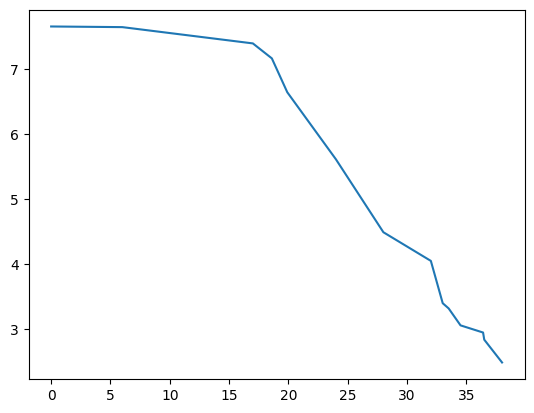

In [20]:
plt.plot(crossection['chain'],crossection['rl'])

In [ ]:
nswsitesdf

In [ ]:
rating = download_rating_table('422201F', url = qldurl, discharge_code= '140' )
crossection = download_cross_section('422201F', url = qldurl)

print(crossection)

combinedtable = unify_tables(rating, crossection)


In [ ]:
combinedtable.to_csv()